### Read the input files to do some descriptive analysis and visualization

In [3]:
import sys
sys.path.append('eval/')

import datetime 
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import CRS

import util_plot
from setup import *

%matplotlib inline
plt.rcParams.update({'font.size': 10})
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [4]:
period = 'after'
dates = pd.read_csv(data_dir+period+"_dates.csv")

In [5]:
rail = pd.read_csv(data_dir+"data_processed/rail_catchment/"+period+"/rail_df.csv")
bus = pd.read_csv(data_dir+"data_processed/rail_catchment/"+period+"/bus_rail_df.csv")
tnc = pd.read_csv(data_dir+"data_processed/rail_catchment/"+period+"/tnc_rail_df.csv")

# Time Series

In [6]:
df = rail
df['day'] = df['ts'] // 96
df = df.groupby(['day','station_id'], as_index=False).sum()
df = df.sort_values(by='day')
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")
df = df[df['station_id'].isin(downtown_stations['STATION_ID'].tolist())]

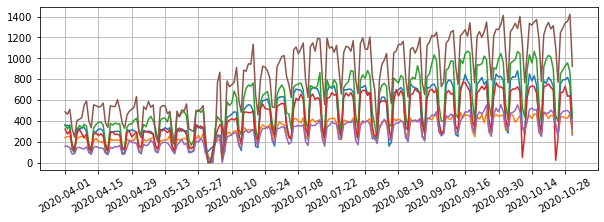

In [17]:
# individual stations
fig, ax = plt.subplots(figsize=(10,3))
for station_id, grp in df.groupby('station_id'):
    r = np.random.rand()
    if r < 0.5:
        ax.plot(dates.iloc[grp['day'].to_numpy()]['index'], grp['count'])#/grp['count'].max())
ax.set_xticks(np.arange(0,len(grp),14))
ax.set_xticklabels(pd.date_range(start="2020-04-01",end="2020-10-31", freq='14D').date, rotation=30)
ax.grid();

In [10]:
dfB = bus
dfB['day'] = dfB['ts'] // 96
dfB = dfB.groupby(['day','STATION_ID'], as_index=False).sum()
dfB = dfB.sort_values(by='day')
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")
dfB = dfB[dfB['STATION_ID'].isin(downtown_stations['STATION_ID'].tolist())]
dfB = dfB.groupby('day').sum()


dfT = tnc
dfT['day'] = dfT['ts'] // 96
dfT = dfT.groupby(['day','STATION_ID'], as_index=False).sum()
dfT = dfT.sort_values(by='day')
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")
dfT = dfT[dfT['STATION_ID'].isin(downtown_stations['STATION_ID'].tolist())]
dfT = dfT.groupby('day').sum()


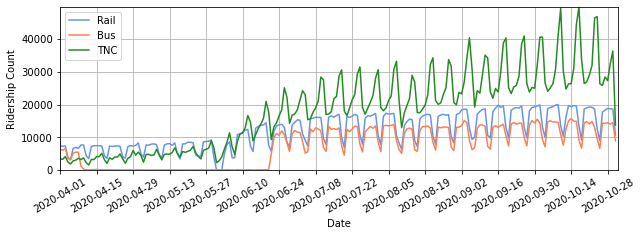

In [12]:
df = df.groupby('day').sum()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['count'], color='cornflowerblue',label='Rail')
ax.plot(dfB['bus_count'], color='coral', label='Bus')
ax.plot(dfT['tnc_count'], color='forestgreen', label = 'TNC')
ax.set_xlim([0,len(df)])
ax.set_ylim([0,dfT['tnc_count'].max()])
ax.set_xticks(np.arange(0,len(df),14))
ax.set_xticklabels(pd.date_range(start="2020-04-01",end="2020-10-31", freq='14D').date, rotation=30)
ax.set_ylabel("Ridership Count")
ax.set_xlabel("Date")
ax.legend()
ax.grid()
fig.savefig(data_dir+"data_processed/"+period+"_demand_viz.png", bbox_inches='tight')

# Spatial Balance

In [19]:
stations = gpd.read_file(data_dir+"data_raw/CTA_Rail/CTA_RailStations.shp")
stations = stations.to_crs(CRS("epsg:4326"))
chicago = (stations.geometry.x.min(), stations.geometry.y.min(), stations.geometry.x.max(), stations.geometry.y.max())
downtown = (-87.645168, 41.872034, -87.623921,  41.889749)


In [20]:
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")

In [21]:
def plot(stations, df, merge_cols_left, merge_cols_right, value_col, title): 
    temp = pd.merge(stations, df, left_on=merge_cols_left, right_on=merge_cols_right)
    scheme = mc.Quantiles(temp[value_col], k=5)
    
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(),
                  hue=value_col, scale=value_col, limits=(5,30), scheme=scheme, legend=True, legend_var='hue',
                  legend_kwargs={'bbox_to_anchor': (1, 0.5), 'frameon': True})
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=chicago)
    # this patch won't show up with webmap, need to investigate further
    #plt.gca().add_patch(Rectangle((-87.645168, 41.872034),0.021247,0.017715,linewidth=5,edgecolor='r',facecolor='r'))
    plt.title(title)

    a = gplt.pointplot(temp, projection=gcrs.WebMercator(), hue=value_col, scale=value_col, limits=(5,30), 
                       scheme=scheme, legend=False)
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=downtown)
    plt.title('Downtown Zoom')


In [41]:
df = pd.merge(rail, bus, how='left', left_on=['ts','station_id'], right_on=['ts','STATION_ID'])
df = pd.merge(df, tnc, how='left', on=['ts','STATION_ID'])
# df['tnc_count'] = 0
df.fillna(0, inplace=True)
temp_agg = df.groupby('station_id', as_index=False).sum()[['station_id','count','bus_count','tnc_count']]

              count     bus_count
count  2.280501e+06  2.280501e+06
mean   6.348197e+00  1.586489e+00
std    7.794834e+00  3.849759e+00
min    1.000000e+00  0.000000e+00
25%    2.000000e+00  0.000000e+00
50%    4.000000e+00  0.000000e+00
75%    8.000000e+00  2.000000e+00
max    2.320000e+02  1.080000e+02


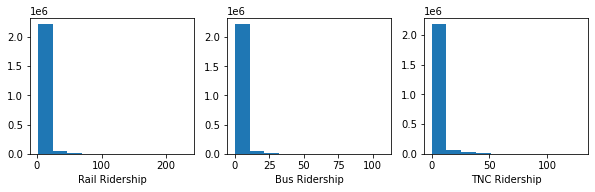

In [43]:
fig, ax = plt.subplots(1,3,figsize=(10,2.5))
ax[0].hist(df['count'])
ax[1].hist(df['bus_count'])
ax[2].hist(df['tnc_count'])
ax[0].set_xlabel("Rail Ridership")
ax[1].set_xlabel("Bus Ridership");
ax[2].set_xlabel("TNC Ridership");

print(df[['count','bus_count']].describe())

In [24]:
temp_agg.columns

Index(['station_id', 'count', 'bus_count', 'tnc_count'], dtype='object')

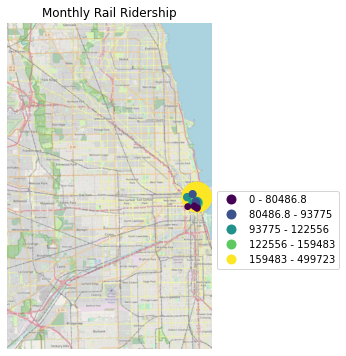

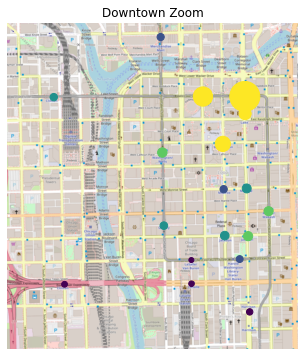

In [25]:
stations = stations[stations['STATION_ID'].isin(downtown_stations['STATION_ID'])]
temp_agg = temp_agg[temp_agg['station_id'].isin(downtown_stations['STATION_ID'])]
plot(stations, temp_agg, 'STATION_ID', 'station_id', 'count', 'Monthly Rail Ridership')

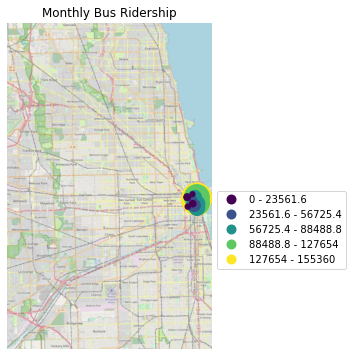

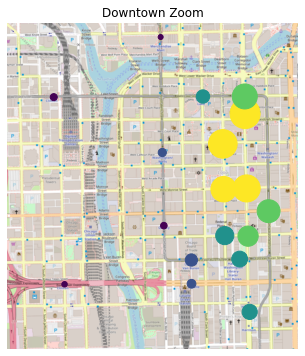

In [26]:
plot(stations, temp_agg, 'STATION_ID', 'station_id', 'bus_count', 'Monthly Bus Ridership')

# Temporal Balance

In [44]:
spatial_agg = df.groupby('ts', as_index=False).sum()[['ts','count','bus_count','tnc_count']]

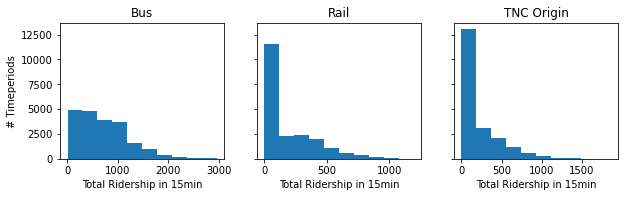

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (10, 2.5), sharey=True)
ax[0].hist(spatial_agg['count'])
ax[1].hist(spatial_agg['bus_count'])
ax[2].hist(spatial_agg['tnc_count'])
ax[0].set_ylabel('# Timeperiods')
ax[0].set_xlabel('Total Ridership in 15min')
ax[1].set_xlabel('Total Ridership in 15min')
ax[2].set_xlabel('Total Ridership in 15min')
ax[0].set_title('Bus')
ax[1].set_title('Rail')
ax[2].set_title('TNC Origin')
plt.show()

# Percent zeros

In [46]:
print("pct zeros in rail:  %.3f" % (np.mean(df['count'] == 0)))
print("pct zeros in bus: %.3f" % (np.mean(df['bus_count'] == 0)))
print("pct zeros in tnc:  %.3f" % (np.mean(df['tnc_count'] == 0)))

pct zeros in rail:  0.000
pct zeros in bus: 0.624
pct zeros in tnc:  0.759


# Extremity of Invidual Spatial-Temporal Values
First row: histogram of 15min ridership in all 100m grids

Second row: histogram of ridership with 0s removed

Third row: histogram of ridership with 0s (low extreme) and top 0.05% values (high extreme) removed

### Conclusion: Values concentrated on the lower end with very extreme high values

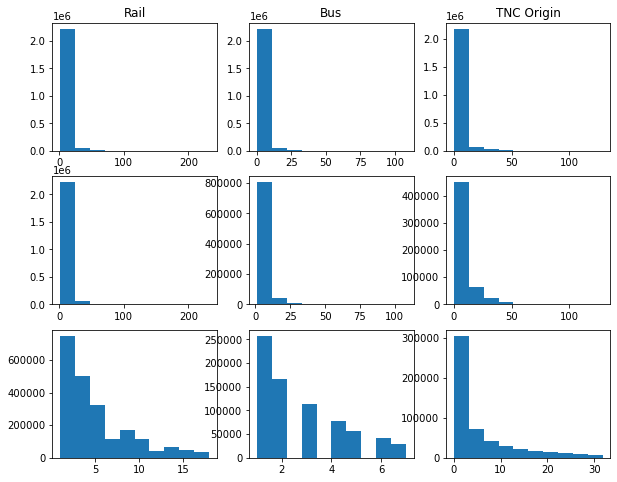

In [47]:
fig, ax = plt.subplots(3, 3, figsize = (10, 8))
ax[0,0].hist(df['count'])
ax[1,0].hist(df[df['count']>0]['count'])
ax[2,0].hist(df[((df['count']<np.percentile(df['count'], 95)) & (df['count']>0))]['count'])
ax[0,0].set_title('Rail')
ax[0,1].set_title('Bus')
ax[0,2].set_title('TNC Origin')

ax[0,1].hist(df['bus_count'])
ax[1,1].hist(df[df['bus_count']>0]['bus_count'])
ax[2,1].hist(df[((df['bus_count']<np.percentile(df['bus_count'], 95)) & (df['bus_count']>0))]['bus_count'])

ax[0,2].hist(df['tnc_count'])
ax[1,2].hist(df[df['tnc_count']>0]['tnc_count'])
ax[2,2].hist(df[((df['tnc_count']<np.percentile(df['tnc_count'], 99)) & (df['tnc_count']>0))]['tnc_count']);

# Deviation from Historical Average

In [48]:
numtimeperiods = 96
df['day'] = df['ts']//96
df['interval15'] = (df['ts'] % 96) 

In [49]:
numdays = np.max(df['day'])+1
start_date = datetime.date(2019, 9, 30)
datelist = [start_date + datetime.timedelta(days = x) for x in range(numdays)]
dowlist = [d.weekday() for d in datelist]

daynumlist = np.arange(numdays)
datedict = dict(zip(daynumlist, datelist))
dowdict = dict(zip(daynumlist, dowlist))

df['date'] = df['day'].map(datedict)
df['dow'] = df['day'].map(dowdict)
df['weekday'] = df['dow'] < 5

In [50]:
his_avg = df.groupby(['weekday','interval15','station_id'], as_index=False).mean()\
            [['weekday','interval15','station_id','count','bus_count','tnc_count']]
his_avg.columns = ['weekday','interval15','station_id','rail_ha','bus_ha','tnc_ha']

In [51]:
df = pd.merge(df, his_avg, on=['weekday','interval15','station_id'])

In [52]:
df['rail_dev'] = np.abs(df['count']-df['rail_ha']) / df['rail_ha']
df['bus_dev'] = np.abs(df['bus_count']-df['bus_ha']) / df['bus_ha']
df['tnc_dev'] = np.abs(df['tnc_count']-df['tnc_ha']) / df['tnc_ha']

In [53]:
df[df['bus_dev'] == np.infty] = np.NaN
df[df['tnc_dev'] == np.infty] = np.NaN

In [54]:
df['tnc_ha']

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
2280496    0.000000
2280497    0.000000
2280498    2.157927
2280499    0.000000
2280500    0.000000
Name: tnc_ha, Length: 2280501, dtype: float64

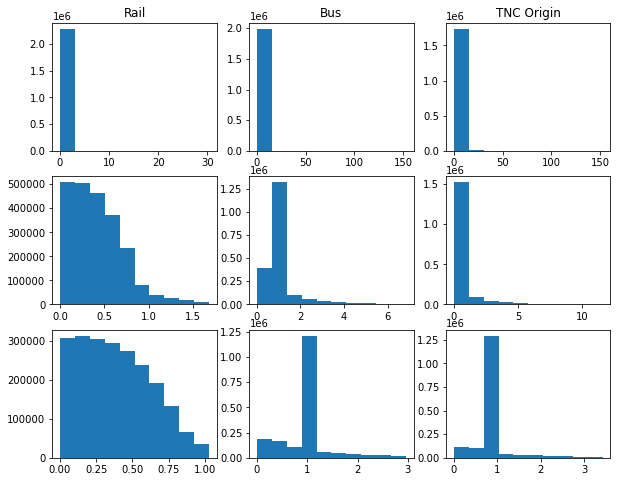

In [55]:
fig, ax = plt.subplots(3, 3, figsize = (10, 8))
ax[0,0].hist(df['rail_dev'])
ax[1,0].hist(df[(np.abs(df['rail_dev'])<np.percentile(np.abs(df['rail_dev']), 99))]['rail_dev'])
ax[2,0].hist(df[(np.abs(df['rail_dev'])<np.percentile(np.abs(df['rail_dev']), 95))]['rail_dev'])

ax[0,0].set_title('Rail')
ax[0,1].set_title('Bus')
ax[0,2].set_title('TNC Origin')

ax[0,1].hist(df['bus_dev'])
ax[1,1].hist(df[(np.abs(df['bus_dev'])<np.nanpercentile(np.abs(df['bus_dev']), 99))]['bus_dev'])
ax[2,1].hist(df[(np.abs(df['bus_dev'])<np.nanpercentile(np.abs(df['bus_dev']), 95))]['bus_dev'])

ax[0,2].hist(df['tnc_dev'])
ax[1,2].hist(df[(np.abs(df['tnc_dev'])<np.nanpercentile(np.abs(df['tnc_dev']), 99))]['tnc_dev'])
ax[2,2].hist(df[(np.abs(df['tnc_dev'])<np.nanpercentile(np.abs(df['tnc_dev']), 95))]['tnc_dev']);

### !!! Take day 21 (Oct 21) time 63, 64 out from TNC observations 
index = 2079, 2080